In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity

In [2]:
def generate_An(n: int, p: float):
    An = np.random.binomial(1, p, size=(n, n))
    np.fill_diagonal(An, val=0)
    An[np.tril_indices(n, k=-1)] = An.T[np.tril_indices(n, k=-1)]

    return An


def generate_Dn(An):
    n = An.shape[0]
    Dn = np.zeros(shape=(n, n))
    degrees = np.matrix(An).sum(axis=1)
    np.fill_diagonal(Dn, degrees)
    Dn = Dn.astype(int)

    return Dn


def generate_Deltan(An, Dn):
    laplacian = Dn - An

    return laplacian


def generate_Ln(An):
    n = An.shape[0]
    degrees = np.matrix(An).sum(axis=1)
    degrees_inv_sqrt = 1/np.sqrt(degrees)
    Dn_inv_sqrt = np.zeros(shape=(n, n))
    np.fill_diagonal(Dn_inv_sqrt, degrees_inv_sqrt)

    Ln = np.identity(n) - np.matmul(np.matmul(Dn_inv_sqrt,An), Dn_inv_sqrt)

    return Ln


def normalized_An_spectra(An, p):
    n = An.shape[0]
    centered_An = An - p
    normed_centered_An = centered_An * 1/np.sqrt(n * p * (1 - p))
    eigen_normed_An = np.linalg.eigvalsh(normed_centered_An)

    return eigen_normed_An


def normalized_Deltan_spectra(Deltan, p, x_range = np.linspace(-5, 5, 100)):
    n = Deltan.shape[0]
    normed_centered_eigen_Laplacian_n = (np.linalg.eigvalsh(Deltan) - n * p) /(np.sqrt(n * p * (1 -p)))
    Fn_Laplacian = [np.sum(normed_centered_eigen_Laplacian_n <= x)/n for x in x_range]

    return np.diff(Fn_Laplacian)


def normalized_Ln_spectra(Ln, p, x_range = np.linspace(-5, 5, 100)):
    n = Ln.shape[0]
    eigen_Ln = np.linalg.eigvalsh(Ln)
    normed_centered_eigen_Ln = (1 - eigen_Ln) * np.sqrt((n * p))
    Fn_Normed_Laplacian = [np.sum(normed_centered_eigen_Ln <= x)/n for x in x_range]

    return np.diff(Fn_Normed_Laplacian)


def generate_block_matrix(n, block_probabilities: list):
    n = 10000
    block_probabilities = [0.5, 0.5]
    n_blocks = len(block_probabilities)
    block_proportions = np.random.random(n_blocks)
    block_proportions_total = np.sum(block_proportions)
    block_proportions_normed = block_proportions/block_proportions_total

    block_sizes = [round(x) for x in block_proportions_normed * n]
    blocks = []
    i_idx = 0
    j_idx = 0

    for block_p, block_n in zip(block_probabilities, block_sizes):
        block = generate_An(block_n, block_p)
        if i_idx == 0:
            zero_x_dim = n - block_n
            zero_y_dim = block_n
            block_row = [block, 
                        np.zeros(shape=(zero_y_dim, zero_x_dim))]
        elif i_idx == n - block_sizes[-1]:
            zero_x_dim = n - block_n
            zero_y_dim = block_n
            block_row = [np.zeros(shape=(zero_y_dim, zero_x_dim)), 
                        block]
        else:
            zero_x_dim_1 = i_idx
            zero_x_dim_2 = n - block_n - i_idx
            zero_y_dim = block_n
            block_row = [np.zeros(shape=(zero_y_dim, zero_x_dim_1)),
                        block,
                        np.zeros(shape=(zero_y_dim, zero_x_dim_2))]

        i_idx += block_n
        j_idx += block_n

        blocks.append(block_row)

    block_matrix = np.block(blocks)

    return block_matrix

In [3]:
block_An = generate_block_matrix(n=1000,
                                 block_probabilities=[0.5, 0.5])
p = 0.5
Dn = generate_Dn(block_An)
laplacian = generate_Deltan(block_An, Dn)
Ln = generate_Ln(block_An)
eigen_normed_An = normalized_An_spectra(block_An, p)
eigen_Ln = np.linalg.eigvalsh(Ln)
eigen_Laplacian_n = np.linalg.eigvalsh(laplacian)
Fn_Laplacian = normalized_Deltan_spectra(laplacian, p)
Fn_Normed_Laplacian = normalized_Ln_spectra(Ln, p)

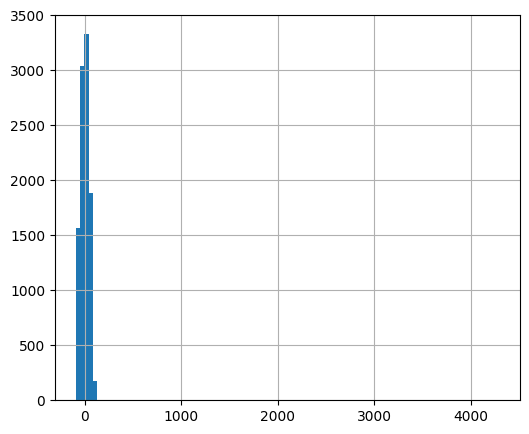

In [6]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.hist(np.linalg.eigvalsh(block_An),
        bins=100)
ax.grid()

# ax.set_title("Spectral Distribution of Centered, Normalized $A_N, N=%s$" % n)

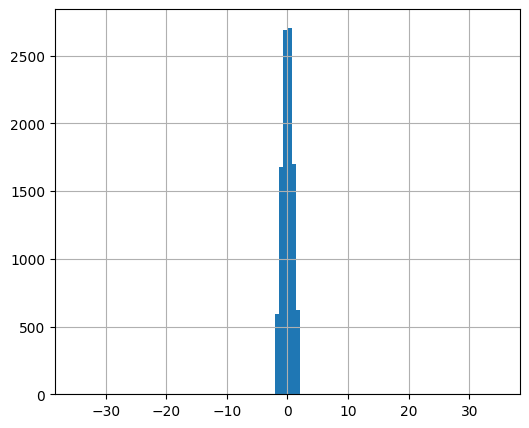

In [4]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.hist(eigen_normed_An,
        bins=100)
ax.grid()

# ax.set_title("Spectral Distribution of Centered, Normalized $A_N, N=%s$" % n)

Text(0.5, 0.98, 'Spectral Distributions of $\\Delta_N$ and $L_N$ of a Block Matrix with 2 Communities, $N=1000, p=0.5$ \n 2 eigenvalues approx. 0')

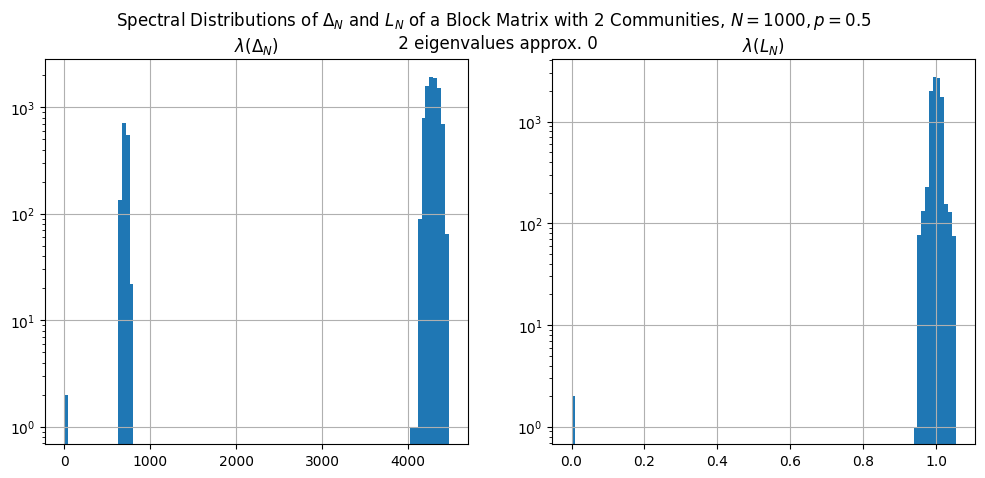

In [21]:
fig, axs = plt.subplots(figsize=(12, 5), ncols=2)

axs[0].hist(eigen_Laplacian_n,
            bins=100)
axs[0].grid()
axs[0].set_title("$\lambda(\Delta_N$)")
axs[0].set_yscale("log")

axs[1].hist(eigen_Ln,
            bins=100)
axs[1].grid()
axs[1].set_title("$\lambda(L_N)$")
axs[1].set_yscale("log")

num_approx_0_eigen = sum(abs(eigen_Ln) <=  1e-12)

fig.suptitle("Spectral Distributions of $\Delta_N$ and $L_N$ of a Block Matrix with 2 Communities, $N=%s, p=%s$ \n %s eigenvalues approx. 0" % (1000, 0.5, num_approx_0_eigen))

Text(0.5, 1.0, '$(1-\\lambda(L_N))(np)^{1/2}(1-p)^{-1/2}$')

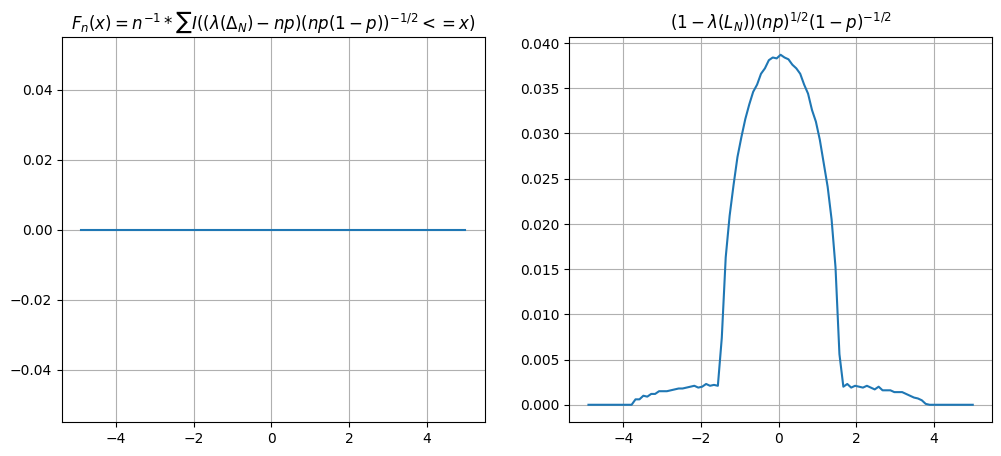

In [7]:
x_range = np.linspace(-5, 5, 100)

fig, axs = plt.subplots(figsize=(12, 5), ncols=2)

axs[0].plot(x_range[1:], Fn_Laplacian)
axs[0].grid()
axs[0].set_title("$F_n(x) = n^{-1} * \sum I((\lambda(\Delta_N) - np)(np(1-p))^{-1/2} <= x)$")

axs[1].plot(x_range[1:],
            Fn_Normed_Laplacian)
axs[1].grid()
axs[1].set_title("$(1-\lambda(L_N))(np)^{1/2}(1-p)^{-1/2}$")

# fig.suptitle("Normalized/Centered Spectral Distributions of Sparse $\Delta_N$ and $L_N, N=%s, p=%s$," % (n, p))